In [1]:
import numpy as np
import matplotlib.pyplot as plt
import operator

In [2]:
def generate_data(n):
    X = np.random.uniform(0,1,n)
    X = np.sin(2*np.pi*X)
    mu, sigma = 0, 0.3 # mean and standard deviation
    noise = np.random.normal(mu, sigma, n)
    y = X + noise
    return X,y

In [3]:
def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

In [4]:
def train_test_split(X, y, test_size=0.2, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
#     print(len(y),split_i)
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

In [5]:
X,y = generate_data(10)
X =  np.reshape(X, (-1,1)) 
X_train, X_test, y_train, y_test = train_test_split(X,y)
print(X_train, X_test, y_train, y_test)

[[ 0.36054768]
 [ 0.68220517]
 [ 0.76425854]
 [-0.16875302]
 [ 0.32589592]
 [ 0.58798267]
 [-0.00667701]
 [-0.72366255]] [[0.18329421]
 [0.66155046]] [ 0.09276203  0.73804385  0.87530722 -0.56716775  0.7405579   0.21148961
  0.07445066 -1.16584808] [0.19827844 0.54925386]


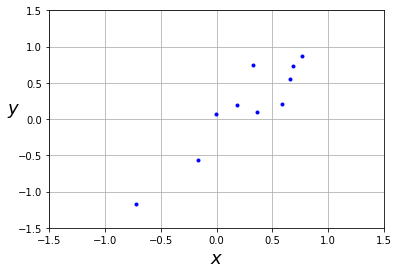

In [6]:
plt.plot(X,y,'b.')
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
_ =plt.axis([-1.5,1.5,-1.5,1.5])
plt.grid()

In [7]:
def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred """
    mse = np.mean(0.5*np.power(y_true - y_pred, 2))
    return mse

In [8]:
class LinearRegression(object):
    """Linear model.
    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    gradient_descent: boolean
        True or false depending if gradient descent should be used when training. If 
        false then we use batch optimization by least squares.
    """
    def __init__(self, n_iterations=100, learning_rate=0.001):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        
    def initialize_weights(self, n_features):
        """ Initialize weights randomly [-1/N, 1/N] """
        limit = 1 / np.power(n_features,0.5)
        self.w = np.random.uniform(-limit, limit, (n_features, ))
        
    def fit(self, X, y):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        self.training_errors = []
        self.initialize_weights(n_features=X.shape[1])

        # Do gradient descent for n_iterations
        for i in range(self.n_iterations):
            y_pred = X.dot(self.w)
            # Calculate l2 loss
            mse = mean_squared_error(y,y_pred)
            self.training_errors.append(mse)
            # Gradient of l2 loss w.r.t w
            grad_w = -(y - y_pred).dot(X)
            # Update the weights
            self.w -= self.learning_rate * grad_w

    def predict(self, X):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

In [9]:
model = LinearRegression( n_iterations=3000, learning_rate=0.05)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
training_mse = model.training_errors[-1]
testing_mse = mean_squared_error(y_test, y_pred)

y_pred_line = model.predict(X)
print (training_mse,testing_mse)

0.032985425909045754 0.008866743582489608


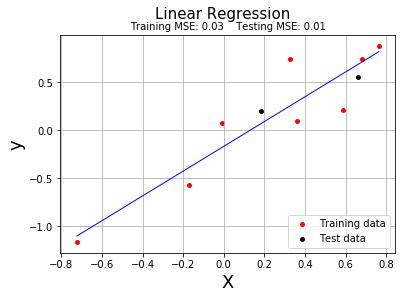

In [10]:
# Plot the results
m1 = plt.scatter(X_train, y_train, color='red', s=15)
m2 = plt.scatter(X_test, y_test, color='black', s=15)
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X,y_pred_line), key=sort_axis)
x, y_pred_line = zip(*sorted_zip)
plt.plot(x, y_pred_line, color='blue', linewidth=1, label="Prediction")
plt.suptitle("Linear Regression",fontsize=15)
plt.title("Training MSE: {0:.2f}    Testing MSE: {1:.2f}".format(training_mse,testing_mse), fontsize=10)
plt.xlabel('X',fontsize=18)
plt.ylabel('y',fontsize=18)
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.grid()
plt.show()

In [11]:
from itertools import combinations_with_replacement
def polynomial_features(X, degree):
    n_samples, n_features = np.shape(X)

    def index_combinations():
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
        flat_combs = [item for sublist in combs for item in sublist]
        return flat_combs
    
    combinations = index_combinations()
    n_output_features = len(combinations)
    X_new = np.empty((n_samples, n_output_features))
    
    for i, index_combs in enumerate(combinations):  
        X_new[:, i] = np.prod(X[:, index_combs], axis=1)

    return X_new

In [12]:
class PolynomialRegression(object):
    """Performs a non-linear transformation of the data before fitting the model
    and doing predictions which allows for doing non-linear regression.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, n_iterations=3000, learning_rate=0.001):
        self.degree = degree
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
    
    def initialize_weights(self, n_features):
        """ Initialize weights randomly [-1/N, 1/N] """
        limit = 1 / np.power(n_features,0.5)
        self.w = np.random.uniform(-limit, limit, (n_features, ))
        
    def fit(self, X, y):
        X = polynomial_features(X, degree=self.degree)
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        self.training_errors = []
        self.initialize_weights(n_features=X.shape[1])

        # Do gradient descent for n_iterations
        for i in range(self.n_iterations):
            y_pred = X.dot(self.w)
            # Calculate l2 loss
            mse = mean_squared_error(y,y_pred)
            self.training_errors.append(mse)
            # Gradient of l2 loss w.r.t w
            grad_w = -(y - y_pred).dot(X)
            # Update the weights
            self.w -= self.learning_rate * grad_w

    def predict(self, X):
        X = polynomial_features(X, degree=self.degree)
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

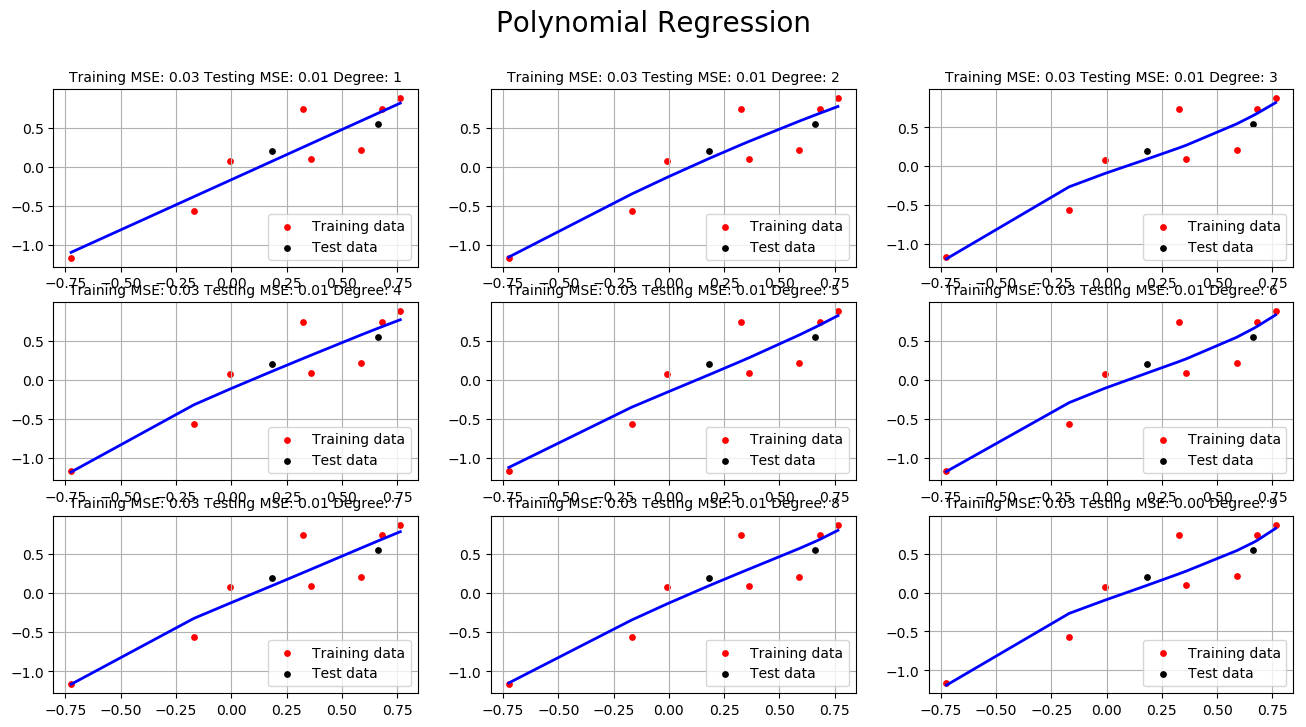

In [13]:
# fig = plt.figure()
plt.figure( figsize=(16, 8), dpi=100)
# fig.subplots_adjust(hspace=1, wspace=1)
for i in range(1,10):
    model = PolynomialRegression(degree = i, n_iterations=3000, learning_rate=0.001)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    training_mse = model.training_errors[-1]
    testing_mse = mean_squared_error(y_test, y_pred)

    y_poly_pred = model.predict(X)
#     print (training_mse,testing_mse)

    # Plot the results
#     ax = fig.add_subplot(3, 3, i)
    plt.subplot(3, 3, i)
    m1 = plt.scatter(X_train, y_train, color='red', s=15)
    m2 = plt.scatter(X_test, y_test, color='black', s=15)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(X,y_poly_pred), key=sort_axis)
    x, y_poly_pred = zip(*sorted_zip)
    plt.plot(x, y_poly_pred, color='blue', linewidth=2, label="Prediction")
    plt.suptitle("Polynomial Regression",fontsize=20)
    plt.title("Training MSE: {0:.2f} Testing MSE: {1:.2f} Degree: {2}".format(training_mse,testing_mse,i), fontsize=10)
    plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
    plt.grid()
plt.show()

In [14]:
# Dataset = 100
X,y = generate_data(100)
X =  np.reshape(X, (-1,1)) 
X_train, X_test, y_train, y_test = train_test_split(X,y)
# print(X_train, X_test, y_train, y_test)

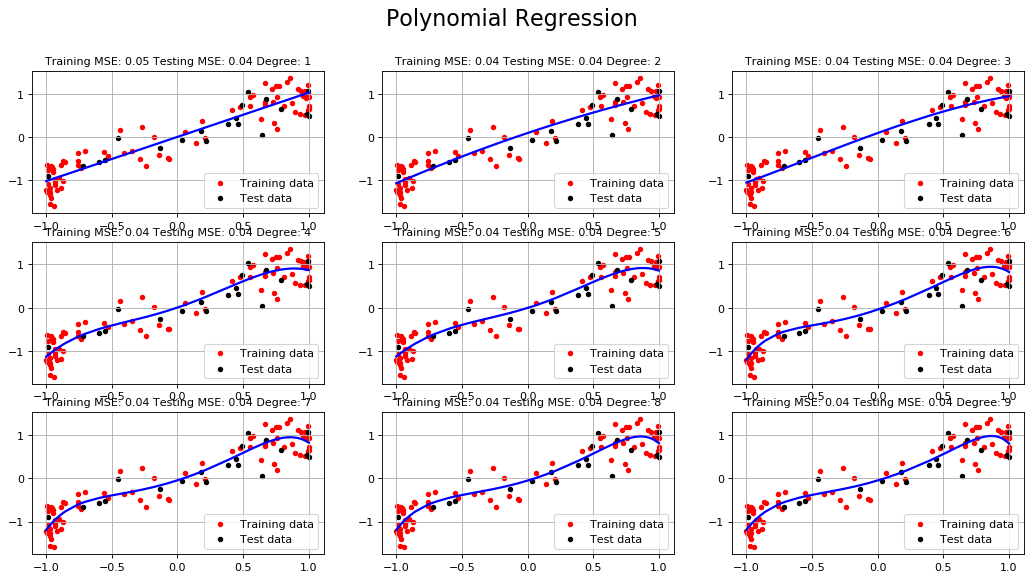

In [15]:
# fig = plt.figure()
plt.figure( figsize=(16, 8), dpi=80)
# fig.subplots_adjust(hspace=1, wspace=1)
for i in range(1,10):
    model = PolynomialRegression(degree = i, n_iterations=3000, learning_rate=0.001)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    training_mse = model.training_errors[-1]
    testing_mse = mean_squared_error(y_test, y_pred)

    y_poly_pred = model.predict(X)
#     print (training_mse,testing_mse)

    # Plot the results
#     ax = fig.add_subplot(3, 3, i)
    plt.subplot(3, 3, i)
    m1 = plt.scatter(X_train, y_train, color='red', s=15)
    m2 = plt.scatter(X_test, y_test, color='black', s=15)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(X,y_poly_pred), key=sort_axis)
    x, y_poly_pred = zip(*sorted_zip)
    plt.plot(x, y_poly_pred, color='blue', linewidth=2, label="Prediction")
    plt.suptitle("Polynomial Regression",fontsize=20)
    plt.title("Training MSE: {0:.2f} Testing MSE: {1:.2f} Degree: {2}".format(training_mse,testing_mse,i), fontsize=10)
    plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
    plt.grid()
plt.show()

In [16]:
# Dataset = 1000
X,y = generate_data(1000)
X =  np.reshape(X, (-1,1)) 
X_train, X_test, y_train, y_test = train_test_split(X,y)
# print(X_train, X_test, y_train, y_test)

C:\Users\shaswat.a\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\shaswat.a\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


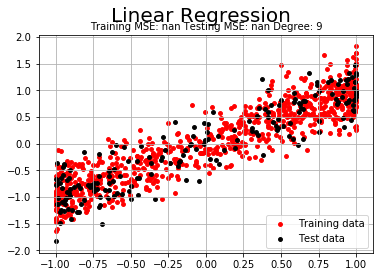

In [17]:
# fig = plt.figure()
# plt.figure( figsize=(16, 8), dpi=90)
# fig.subplots_adjust(hspace=1, wspace=1)
model = LinearRegression( n_iterations=3000, learning_rate=0.05)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
training_mse = model.training_errors[-1]
testing_mse = mean_squared_error(y_test, y_pred)

y_poly_pred = model.predict(X)

m1 = plt.scatter(X_train, y_train, color='red', s=15)
m2 = plt.scatter(X_test, y_test, color='black', s=15)
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='blue', linewidth=2, label="Prediction")
plt.suptitle("Linear Regression",fontsize=20)
plt.title("Training MSE: {0:.2f} Testing MSE: {1:.2f} Degree: {2}".format(training_mse,testing_mse,i), fontsize=10)
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.grid()
plt.show()

In [18]:
def mean_absolute_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred """
    mae = np.mean(0.5*np.absolute(y_true - y_pred))
    return mae

def fourth_power_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred """
    fpe = np.mean(0.5*np.power(y_true - y_pred, 4))
    return fpe

In [19]:
class LinearRegressionVariant(object):
    """Linear model.
    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    gradient_descent: boolean
        True or false depending if gradient descent should be used when training. If 
        false then we use batch optimization by least squares.
    """
    def __init__(self, n_iterations=100, learning_rate=0.001,error = 'mse'):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.error = error
        
    def initialize_weights(self, n_features):
        """ Initialize weights randomly [-1/N, 1/N] """
        limit = 1 / np.power(n_features,0.5)
        self.w = np.random.uniform(-limit, limit, (n_features, ))
        
    def fit(self, X, y):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        self.training_errors = []
        self.initialize_weights(n_features=X.shape[1])
        
        if self.error == 'mse':
            # Do gradient descent for n_iterations
            for i in range(self.n_iterations):
                y_pred = X.dot(self.w)
                # Calculate l2 loss
                mse = mean_squared_error(y,y_pred)
                self.training_errors.append(mse)
                # Gradient of l2 loss w.r.t w
                grad_w = -(y - y_pred).dot(X)
                # Update the weights
                self.w -= self.learning_rate * grad_w
        elif self.error == 'mae':
            # Do gradient descent for n_iterations
            for i in range(self.n_iterations):
                y_pred = X.dot(self.w)
                # Calculate l2 loss
                mse = mean_absolute_error(y,y_pred)
                self.training_errors.append(mse)
                # Gradient of l2 loss w.r.t w
                grad_w = -(y - y_pred).dot(X)
                # Update the weights
                self.w -= self.learning_rate * grad_w
        elif self.error == 'fpe':
            # Do gradient descent for n_iterations
            for i in range(self.n_iterations):
                y_pred = X.dot(self.w)
                # Calculate l2 loss
                mse = fourth_power_error(y,y_pred)
                self.training_errors.append(mse)
                # Gradient of l2 loss w.r.t w
                grad_w = -(y - y_pred).dot(X)
                # Update the weights
                self.w -= self.learning_rate * grad_w
                
    def predict(self, X):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

In [20]:
X,y = generate_data(500)
X =  np.reshape(X, (-1,1)) 
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [21]:
model1 = LinearRegressionVariant(n_iterations=3000, learning_rate=0.001,error = 'mse')
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
training_mse = model1.training_errors[-1]
testing_mse = mean_squared_error(y_test, y_pred)

y_pred_line = model1.predict(X)
print (training_mse,testing_mse)

0.04148092829537057 0.050523386844799074


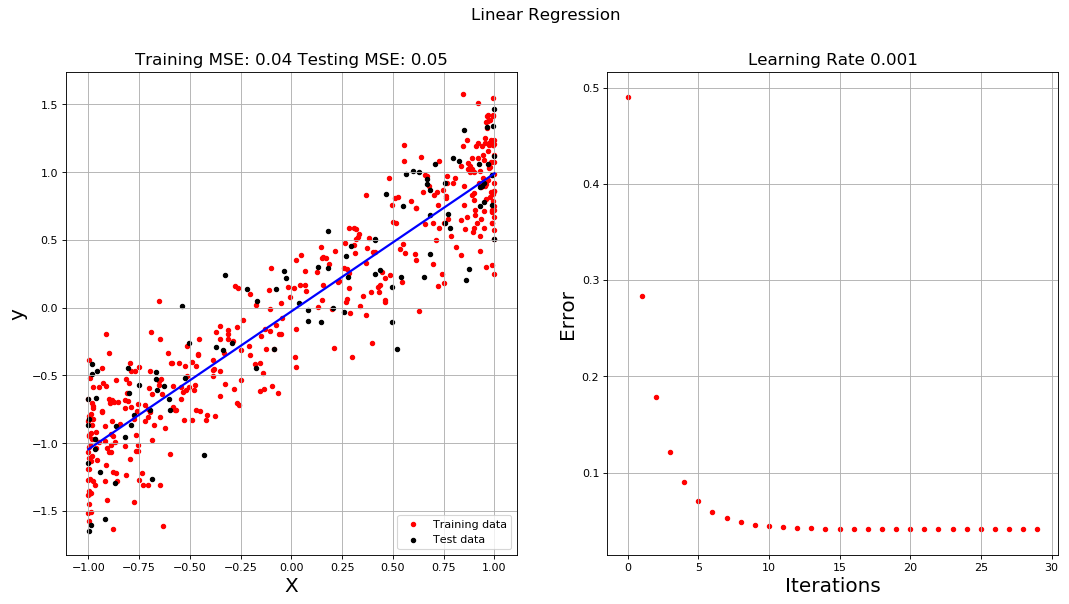

In [22]:
# Plot the results
plt.figure( figsize=(16, 8), dpi=80)
plt.subplot(1, 2, 1)
m1 = plt.scatter(X_train, y_train, color='red', s=15)
m2 = plt.scatter(X_test, y_test, color='black', s=15)
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X,y_pred_line), key=sort_axis)
x, y_pred_line = zip(*sorted_zip)
plt.plot(x, y_pred_line, color='blue', linewidth=2, label="Prediction")
plt.suptitle("Linear Regression",fontsize=15)
plt.title("Training MSE: {0:.2f} Testing MSE: {1:.2f}".format(training_mse,testing_mse), fontsize=15)
plt.xlabel('X',fontsize=18)
plt.ylabel('y',fontsize=18)
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(np.arange(30), model1.training_errors[:30], color='red', s=15)
plt.title("Learning Rate {0:.3f}".format(model1.learning_rate), fontsize=15)
plt.xlabel('Iterations',fontsize=18)
plt.ylabel('Error',fontsize=18)
plt.grid()
plt.show()

In [23]:
model2 = LinearRegressionVariant(n_iterations=3000, learning_rate=0.0005,error = 'mae')
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
training_mse = model2.training_errors[-1]
testing_mse = mean_absolute_error(y_test, y_pred)

y_pred_line = model2.predict(X)
print (training_mse,testing_mse)

0.11741057635241915 0.12868190621773823


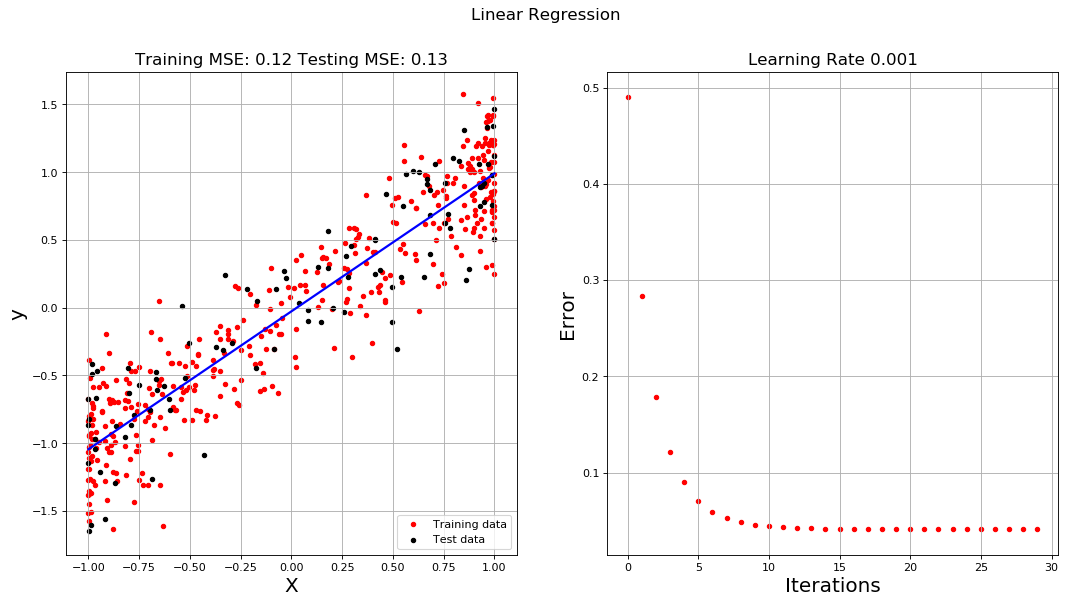

In [24]:
# Plot the results
plt.figure( figsize=(16, 8), dpi=80)
plt.subplot(1, 2, 1)
m1 = plt.scatter(X_train, y_train, color='red', s=15)
m2 = plt.scatter(X_test, y_test, color='black', s=15)
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X,y_pred_line), key=sort_axis)
x, y_pred_line = zip(*sorted_zip)
plt.plot(x, y_pred_line, color='blue', linewidth=2, label="Prediction")
plt.suptitle("Linear Regression",fontsize=15)
plt.title("Training MSE: {0:.2f} Testing MSE: {1:.2f}".format(training_mse,testing_mse), fontsize=15)
plt.xlabel('X',fontsize=18)
plt.ylabel('y',fontsize=18)
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.grid()
plt.subplot(1, 2, 2)
plt.scatter(np.arange(30), model1.training_errors[:30], color='red', s=15)
plt.title("Learning Rate {0:.3f}".format(model2.learning_rate), fontsize=15)
plt.xlabel('Iterations',fontsize=18)
plt.ylabel('Error',fontsize=18)
plt.grid()
plt.show()

In [25]:
model3 = LinearRegressionVariant(n_iterations=300, learning_rate=0.001,error = 'fpe')
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
training_mse = model3.training_errors[-1]
testing_mse = fourth_power_error(y_test, y_pred)

y_pred_line = model3.predict(X)
print (training_mse,testing_mse)

0.009678944241241 0.012987400472763103


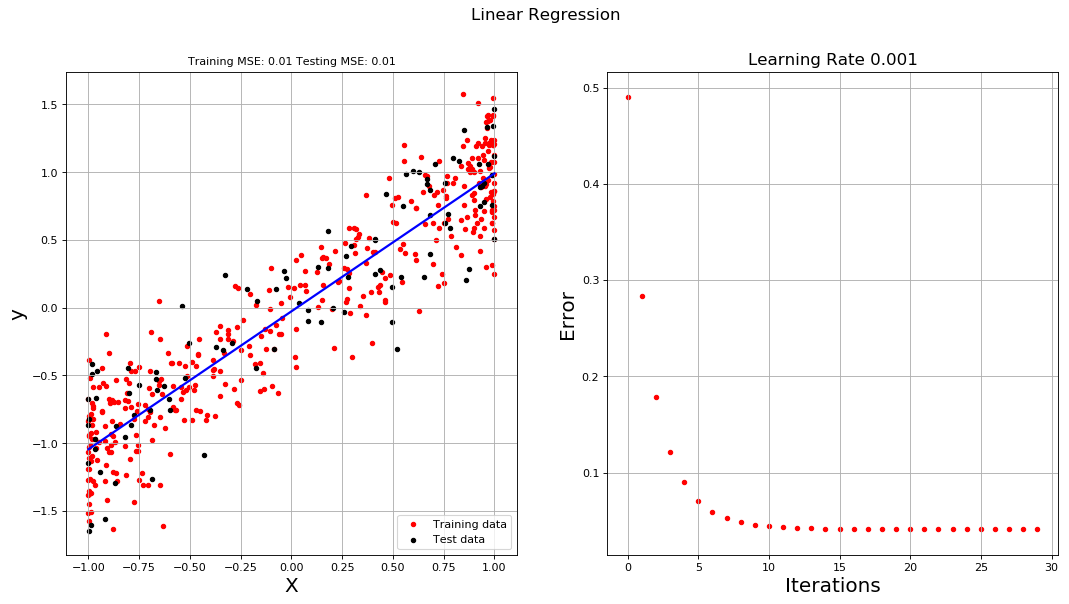

In [26]:
# Plot the results
plt.figure( figsize=(16, 8), dpi=80)
plt.subplot(1, 2, 1)
m1 = plt.scatter(X_train, y_train, color='red', s=15)
m2 = plt.scatter(X_test, y_test, color='black', s=15)
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X,y_pred_line), key=sort_axis)
x, y_pred_line = zip(*sorted_zip)
plt.plot(x, y_pred_line, color='blue', linewidth=2, label="Prediction")
plt.suptitle("Linear Regression",fontsize=15)
plt.title("Training MSE: {0:.2f} Testing MSE: {1:.2f}".format(training_mse,testing_mse), fontsize=10)
plt.xlabel('X',fontsize=18)
plt.ylabel('y',fontsize=18)
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.grid()
plt.subplot(1, 2, 2)
plt.scatter(np.arange(30), model1.training_errors[:30], color='red', s=15)
plt.xlabel('Iterations',fontsize=18)
plt.ylabel('Learning Rate',fontsize=18)
plt.title("Learning Rate {0:.3f}".format(model3.learning_rate), fontsize=15)
plt.xlabel('Iterations',fontsize=18)
plt.ylabel('Error',fontsize=18)
plt.grid()
plt.show()